In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt

import ray

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess
from multi_run_v3.momentum import make_group_mask
from multi_run_v3.momentum_strategy import *
from multi_run_v2.initialize_v2 import make_market_index
#from multi_run_v3.backtest import simulate_longonly, simulate_longshort

2023-08-19 21:16:47,863	INFO worker.py:1625 -- Started a local Ray instance.


In [26]:
data = pd.read_pickle("Data/binance_futures.pickle")

days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [27]:
"vol","close","mktcap","coin_id" 

('vol', 'close', 'mktcap', 'coin_id')

In [29]:
data.index = data.open_time
data.coin = data.coin.str.replace('USDT', '').str.replace('BUSD','')
print(len(data))

data2 = data.loc[:, ['close', 'volume', 'coin', 'count']].drop_duplicates()
data2.columns = ['close', 'vol', 'coin_id', 'mktcap']
data2

102091


,close,vol,coin_id,mktcap
open_time,,,,
2019-12-31,129.120000,6.477434e+05,ETH,54948
2019-12-31,7189.000000,8.920344e+04,BTC,157014
2019-12-31,204.720000,3.208150e+05,BCH,46150
2020-01-01,130.620000,4.660639e+05,ETH,40168
2020-01-01,7197.570000,5.680133e+04,BTC,101871
...,...,...,...,...
2023-07-31,0.077893,4.783946e+07,TRX,18225
2023-07-31,0.223200,1.053012e+08,AGIX,98863
2023-07-31,0.623800,5.485799e+06,COMBO,32635


In [84]:
data_pp = DataPreprocess()
data_pp.initialize(data=data2)
data_pp.make_mask(mktcap_thresh=None,
                  vol_thresh=1_000_000,
                  ma=True)

In [85]:
mkt = make_market_index(data_pp.price_df,
                        data_pp.mktcap_df,
                        data_pp.vol_df,
                        1_000_000,
                        1_000_000,
                        True)

In [86]:
price_df = data_pp.price_df
weekly_rtn_df = data_pp.weekly_rtn_df
mask_df = data_pp.mask
day_of_week = 'SUN'
n_group = 5
coin_group = 10
reb = '1'

In [87]:
last_day = price_df.index[-1]

weekly_mask = mask_df.resample(reb + "W-" + day_of_week).last()[:last_day]
weekly_rtn = weekly_rtn_df.resample(reb + "W-" + day_of_week).last()[:last_day]
weekly_rtn_masked = weekly_rtn * weekly_mask 
    
# 언제부터 시작하는 지 (최소 q*n개의 코인이 필요)
cnt = weekly_rtn_masked.count(1)
thresh = cnt[cnt >= (n_group * coin_group)] # 여기서 start date가 나온다 / 각 그룹당 최소 20개의 코인이 필요함
strategy_start = thresh.index[0] 

In [90]:
# Ray Data 생성
ray_price =     ray.put(data_pp.price_df.loc['2020-02-10':])
ray_mktcap =    ray.put(data_pp.mktcap_df.loc['2020-02-10':])
ray_vol =       ray.put(data_pp.vol_df.loc['2020-02-10':])
ray_daily_rtn = ray.put(data_pp.daily_rtn_df.loc['2020-02-10':])
ray_weekly_rtn =ray.put(data_pp.weekly_rtn_df.loc['2020-02-10':])
ray_mask =      ray.put(data_pp.mask.loc['2020-02-10':])

In [60]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

Volume_weighted_capped

In [110]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_volume_weighted.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       vol_df = ray_vol,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       #num_cap=0.95, # 5%,
                                                                       coin_group=10,
                                                                       leverage_ratio=2
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [111]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [112]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c2 = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c2[pf] = concat_series_c.sort_index().pct_change().fillna(0)

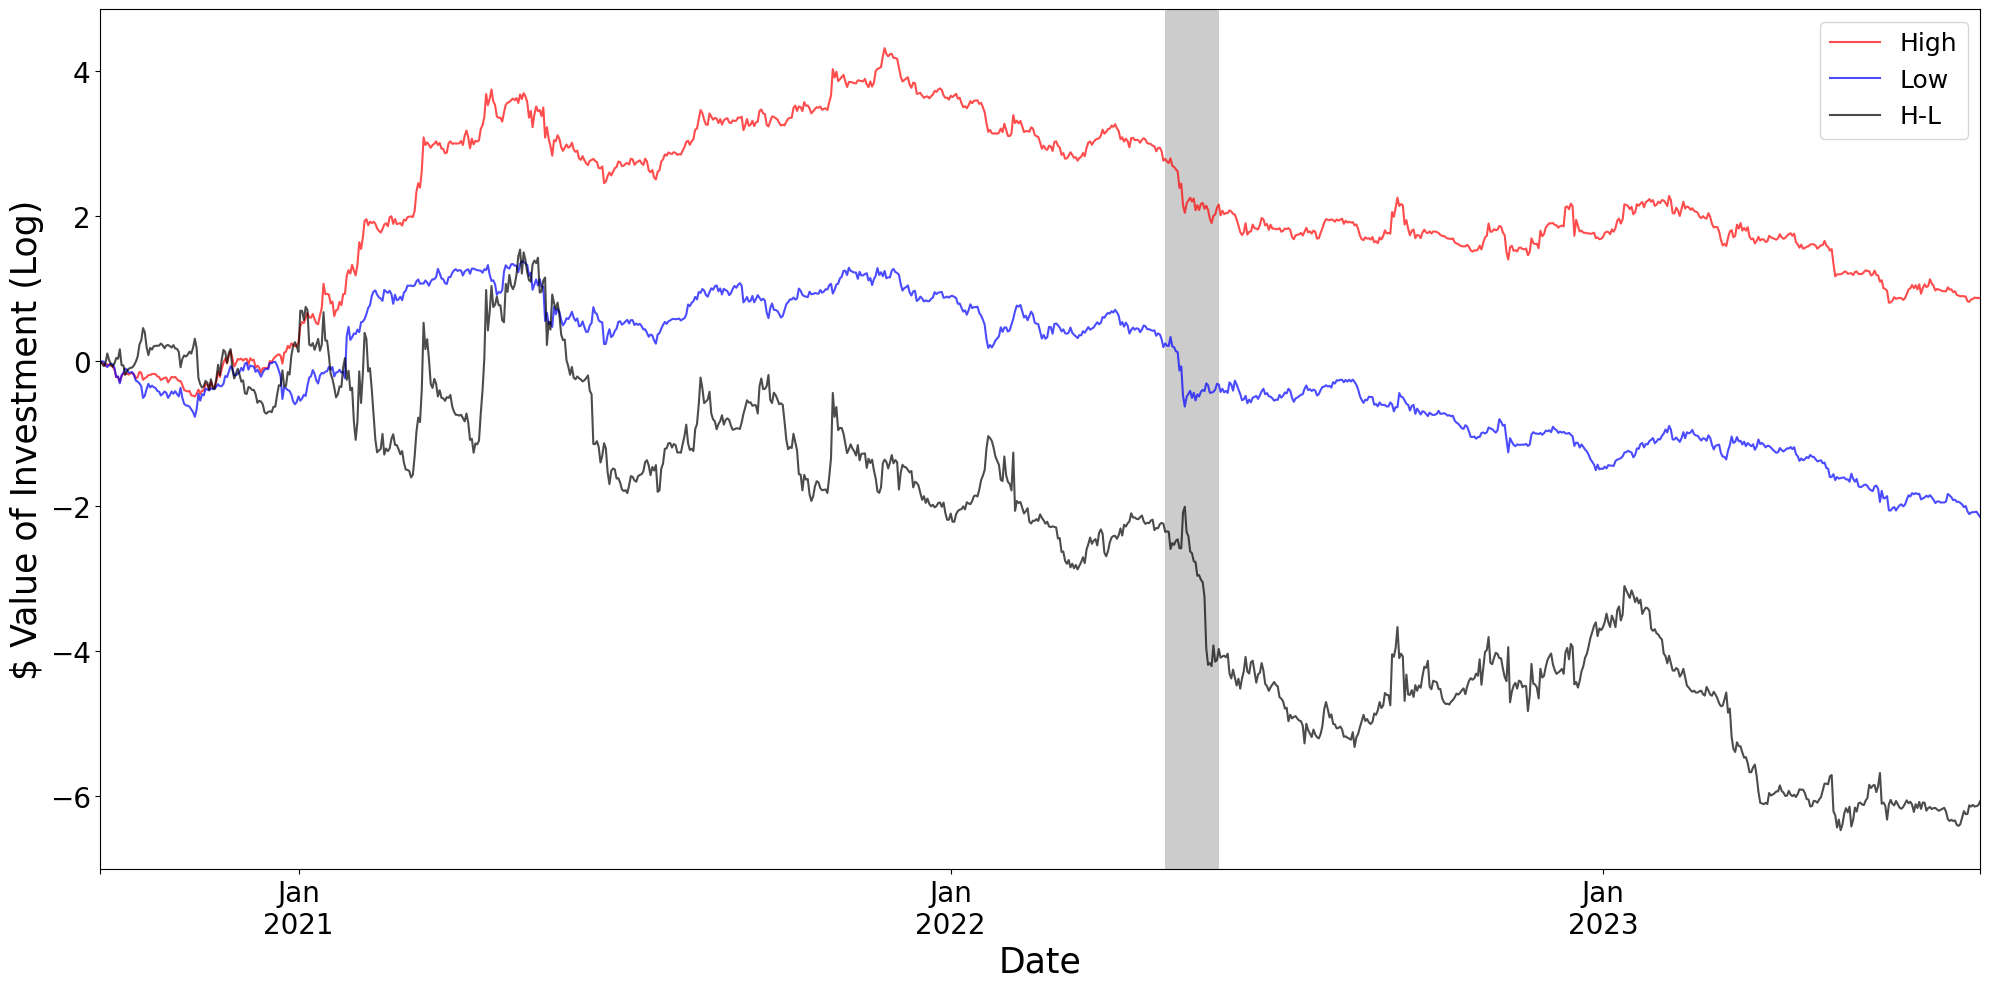

In [113]:
import matplotlib.dates as mdates

np.log((fin_c2["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c2["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c2["LS"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment (Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

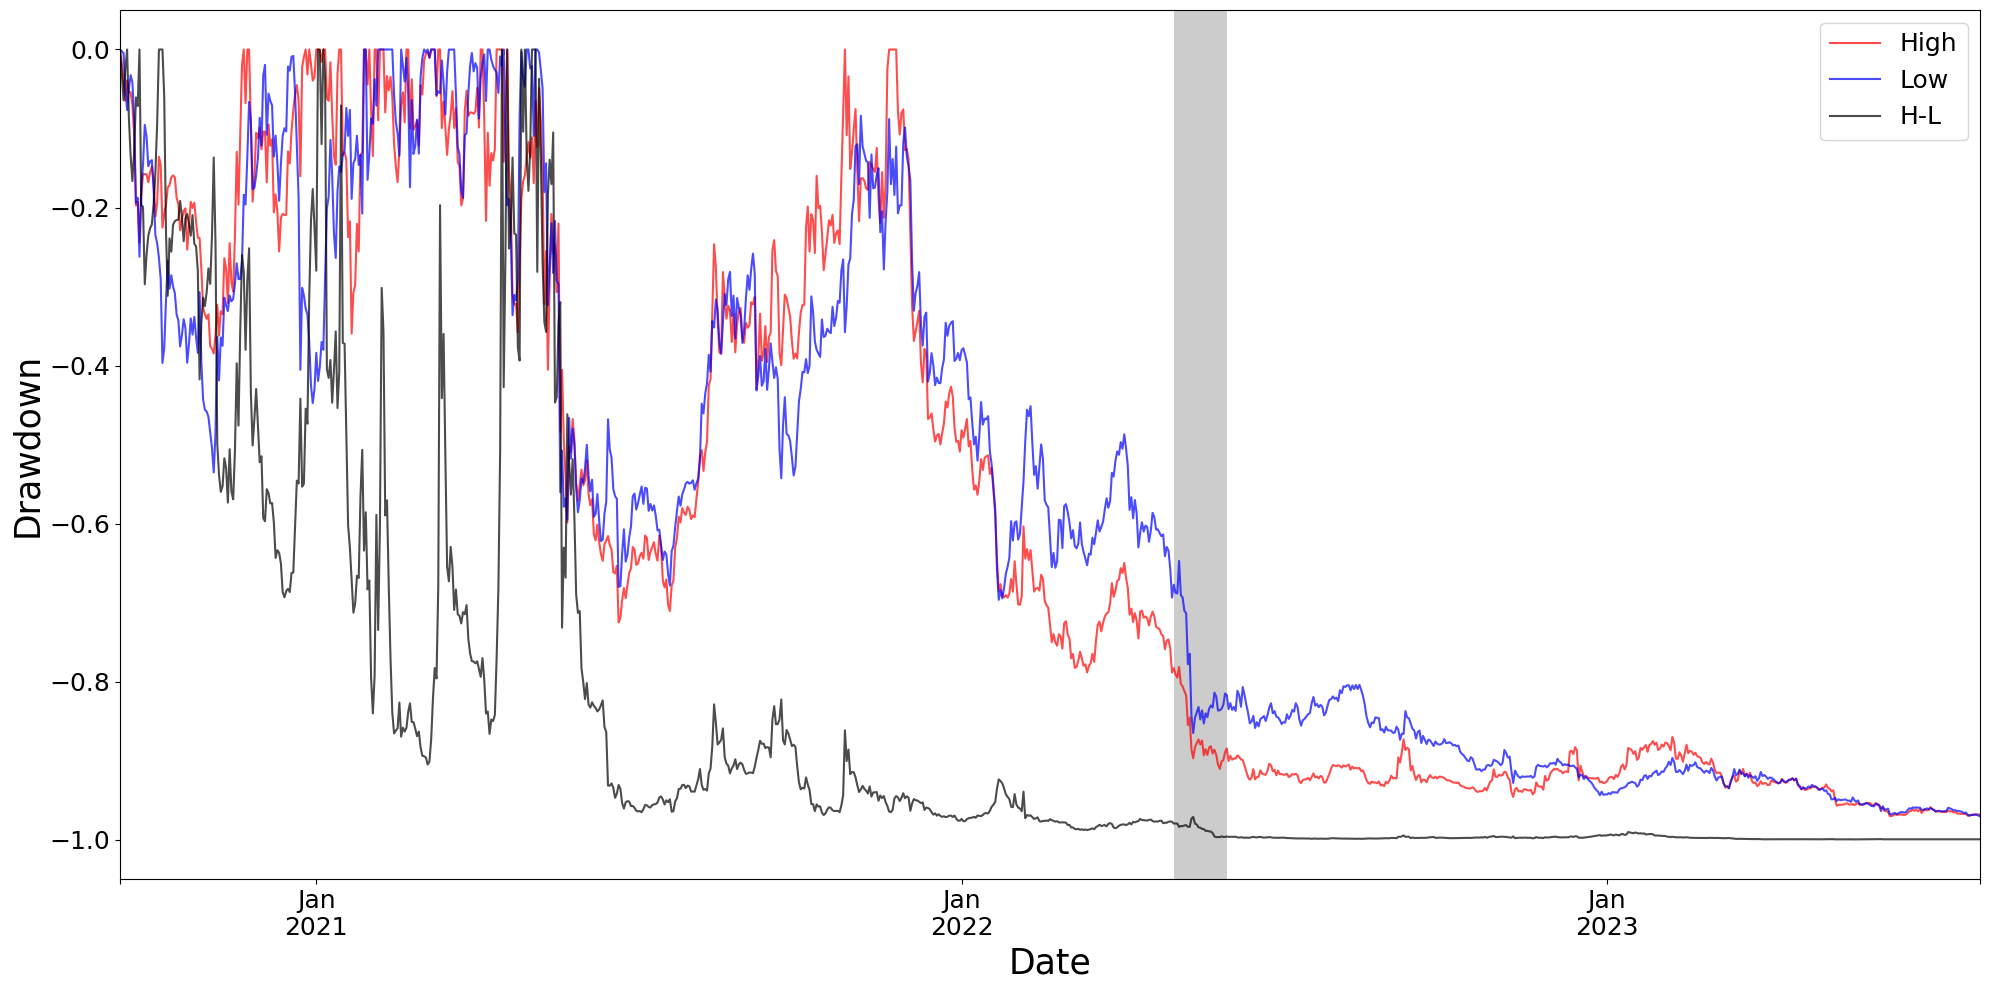

In [114]:
high = (fin_c2["Long_Q5"] + 1).cumprod()
low = (fin_c2["Long_Q1"] + 1).cumprod()
h_l = (fin_c2["LS"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=18)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.legend(["High", "Low","H-L"], fontsize=18)

plt.minorticks_off()
plt.tight_layout();

In [115]:
mytool.print_statistics(fin_c2)

,Long_Q1,Long_Q2,Long_Q3,Long_Q4,Long_Q5,LS
Mean,0.060660,1.159710,0.807030,0.948230,1.321300,2.651840
STD,1.285402,1.267406,1.079363,1.078871,1.457408,3.301594
CAGR,-0.524700,0.537400,0.242100,0.430500,0.359400,-0.877100
MDD,0.971000,0.899000,0.924000,0.880000,0.970000,1.000000
Sharpe,0.047191,0.915027,0.747691,0.878909,0.906610,0.803200


No cap

In [ ]:
momentum_cmkt = {}

momentum_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                                mktcap_df=ray_mktcap,
                                                                daily_rtn_df = ray_daily_rtn,
                                                                weekly_rtn_df = ray_weekly_rtn,
                                                                mask_df = ray_mask,
                                                                fee_rate = 0.0015,
                                                                n_group=5,
                                                                day_of_week=day,
                                                                ) 
              for day in days_lst]

momentum_result = ray.get(momentum_future)

In [ ]:
momentum_result_dict = {"MON":momentum_result[0],
                        "TUE":momentum_result[1],
                        "WED":momentum_result[2],
                        "THU":momentum_result[3],
                        "FRI":momentum_result[4],
                        "SAT":momentum_result[5],
                        "SUN":momentum_result[6]}

In [ ]:
final = {}

for day in days_lst:
    df_day = momentum_result_dict[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final[day] = concat_df

fin = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series = pd.concat([df[pf] for key, df in final.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series.index[0] - pd.Timedelta(days=1)
    concat_series[start_idx] = 7
    fin[pf] = concat_series.sort_index().pct_change().fillna(0)

In [ ]:
np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("\$ Value of Investment(Log)", fontsize=18)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
mytool.print_statistics(fin_c)

j-k Momentum

In [ ]:
momentum_capped_cmkt = {}

momentum_capped_future = [jk_momentum_value_weighted_capped.remote(mktcap_df=ray_mktcap,
                                                                   daily_rtn_df = ray_daily_rtn,
                                                                   mask_df = ray_mask,
                                                                   fee_rate = 0.0015,
                                                                   n_group=5,
                                                                   day_of_week=day,
                                                                   num_cap=0.95 # 5%
                                                                    ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [ ]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [ ]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [ ]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [ ]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment(Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS-cross"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["High", "Low","H-L"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
#fin_c["MKT"] = mkt.loc["2017-12-30":]
stat = mytool.print_statistics(fin_c).iloc[[0,2,3]]
stat.loc["Sharpe"] = stat.loc["CAGR"] / stat.loc["STD"]
stat.iloc[:3, :] = (stat.iloc[:3, :] * 100).round(2)

stat2 = stat.loc[:, ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]]
stat2.columns = ["1","2","3","4","5","5-1"]
print(stat2.to_latex())
#stat2

vol weighted jk

In [ ]:
momentum_capped_cmkt = {}

momentum_capped_future = [jk_volume_weighted_capped.remote(mktcap_df=ray_mktcap,
                                                           vol_df = ray_vol,
                                                           daily_rtn_df = ray_daily_rtn,
                                                           mask_df = ray_mask,
                                                           fee_rate = 0.0015,
                                                           n_group=5,
                                                           day_of_week=day,
                                                           num_cap=0.95 # 5%
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [ ]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [ ]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [ ]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [ ]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment(Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS-cross"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["High", "Low","H-L"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
#fin_c["MKT"] = mkt.loc["2017-12-30":]
stat = mytool.print_statistics(fin_c).iloc[[0,2,3]]
stat.loc["Sharpe"] = stat.loc["CAGR"] / stat.loc["STD"]
stat.iloc[:3, :] = (stat.iloc[:3, :] * 100).round(2)

stat2 = stat.loc[:, ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]]
stat2.columns = ["1","2","3","4","5","5-1"]
print(stat2.to_latex())
#stat2